In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import requests
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt

from astropy.stats import LombScargle

from kepler_op import KeplerOp
kepler = KeplerOp()

ModuleNotFoundError: No module named 'kepler_op'

In [ ]:
from pymc3.step_methods.arraystep import ArrayStepShared, metrop_select, Competence
from pymc3.step_methods.metropolis import delta_logp
from pymc3.theanof import floatX
import theano

class PeriodStep(ArrayStepShared):
    name = 'period'

    default_blocked = False
    generates_stats = True
    stats_dtypes = [{
        'accept': np.float64,
    }]

    def __init__(self, var, model=None, mode=None, **kwargs):

        model = pm.modelcontext(model)
        self.orig_var = var
        vars = pm.inputvars([var])
        self.accepted = 0
        self.mode = mode

        shared = pm.make_shared_replacements(vars, model)
        self.delta_logp = delta_logp(model.logpt, vars, shared)
        
        self.backward_val = theano.function([var],
                                            var.transformation.backward(var))
        
        self.values = np.array(sorted(set([i / j for i in range(1, 6) for j in range(1, i)])))
        
        super(PeriodStep, self).__init__(vars, shared)

    def astep(self, q0):
        v = np.random.choice(self.values)
        if np.random.rand() < 0.5:
            v = 1.0 / v
        delta = np.zeros(len(q0))
        delta[np.random.randint(len(delta))] = np.log(v)

        q = floatX(
            self.orig_var.transformation.forward_val(
                self.backward_val(q0) + delta))
        if not np.all(np.isfinite(q)):
            q = floatX(q0)

        accept = self.delta_logp(q, q0)
        q_new, accepted = metrop_select(accept, q, q0)
        self.accepted += accepted

        stats = {
            'accept': np.exp(accept),
        }

        return q_new, [stats]

    @staticmethod
    def competence(var, has_grad):
        return Competence.COMPATIBLE

In [5]:
def lomb_scargle_estimator(x, y, yerr=None,
                           min_period=None, max_period=None,
                           filter_period=None,
                           max_peaks=2,
                           **kwargs):
    """
    Estimate period of a time series using the periodogram
    Args:
        x (ndarray[N]): The times of the observations
        y (ndarray[N]): The observations at times ``x``
        yerr (Optional[ndarray[N]]): The uncertainties on ``y``
        min_period (Optional[float]): The minimum period to consider
        max_period (Optional[float]): The maximum period to consider
        filter_period (Optional[float]): If given, use a high-pass filter to
            down-weight period longer than this
        max_peaks (Optional[int]): The maximum number of peaks to return
            (default: 2)
    Returns:
        A dictionary with the computed ``periodogram`` and the parameters for
        up to ``max_peaks`` peaks in the periodogram.
    """
    if min_period is not None:
        kwargs["maximum_frequency"] = 1.0 / min_period
    if max_period is not None:
        kwargs["minimum_frequency"] = 1.0 / max_period

    # Estimate the power spectrum
    model = LombScargle(x, y, yerr)
    freq, power = model.autopower(method="fast", normalization="psd", **kwargs)
    power /= len(x)
    power_est = np.array(power)

    # Filter long periods
    if filter_period is not None:
        freq0 = 1.0 / filter_period
        filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
        power *= filt

    # Find and fit peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for i in peak_inds[:max_peaks]:
        A = np.vander(freq[i-1:i+2], 3)
        w = np.linalg.solve(A, np.log(power[i-1:i+2]))
        sigma2 = -0.5 / w[0]
        freq0 = w[1] * sigma2
        peaks.append(dict(
            log_power=w[2] + 0.5*freq0**2 / sigma2,
            period=1.0 / freq0,
            period_uncert=np.sqrt(sigma2 / freq0**4),
        ))

    return dict(
        periodogram=(freq, power_est),
        peaks=peaks,
    )

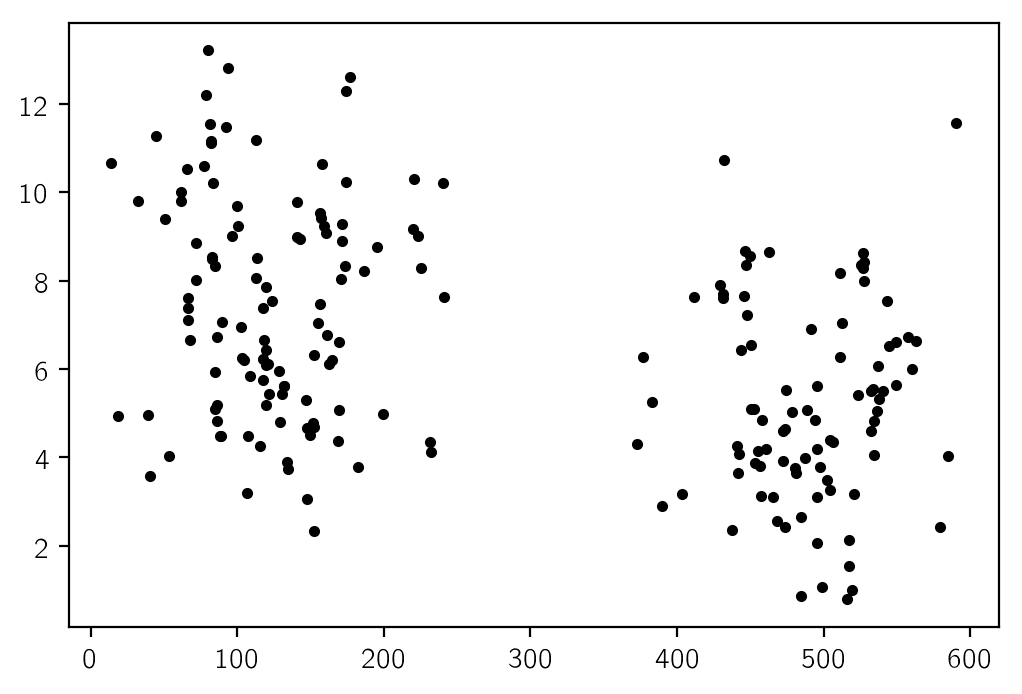

In [6]:
number = 2
df = pd.read_csv("https://raw.githubusercontent.com/EPRV3EvidenceChallenge/Inputs/master/data/rvs_{0:04d}.txt".format(number),
                 header=None, delim_whitespace=True, names=["t", "vel", "errvel"])
priors = pd.read_csv("https://github.com/EPRV3EvidenceChallenge/Inputs/raw/master/data/prior_bounds_{0:04d}.txt".format(number),
                     header=None, names=["param", "num", "lower", "upper"])

t = np.array(df.t, dtype=float)
y = np.array(df.vel, dtype=float)
yerr = np.array(df.errvel, dtype=float)
plt.plot(t, y, ".k");

[{'amp': 2.1665608829662286,
  'log_power': 0.3839314171591468,
  'period': 15.946085987072676,
  'period_uncert': 0.15478275694529198,
  'phase': 1.787352359231423},
 {'amp': 1.190529122058875,
  'log_power': -0.8329412152784244,
  'period': 19.453156952622574,
  'period_uncert': 0.22686163259170133,
  'phase': 0.6006967781320341},
 {'amp': 1.1098070036944678,
  'log_power': -1.0728965725439394,
  'period': 117.53538247994037,
  'period_uncert': 7.831468608317536,
  'phase': -2.6253276485851793}]

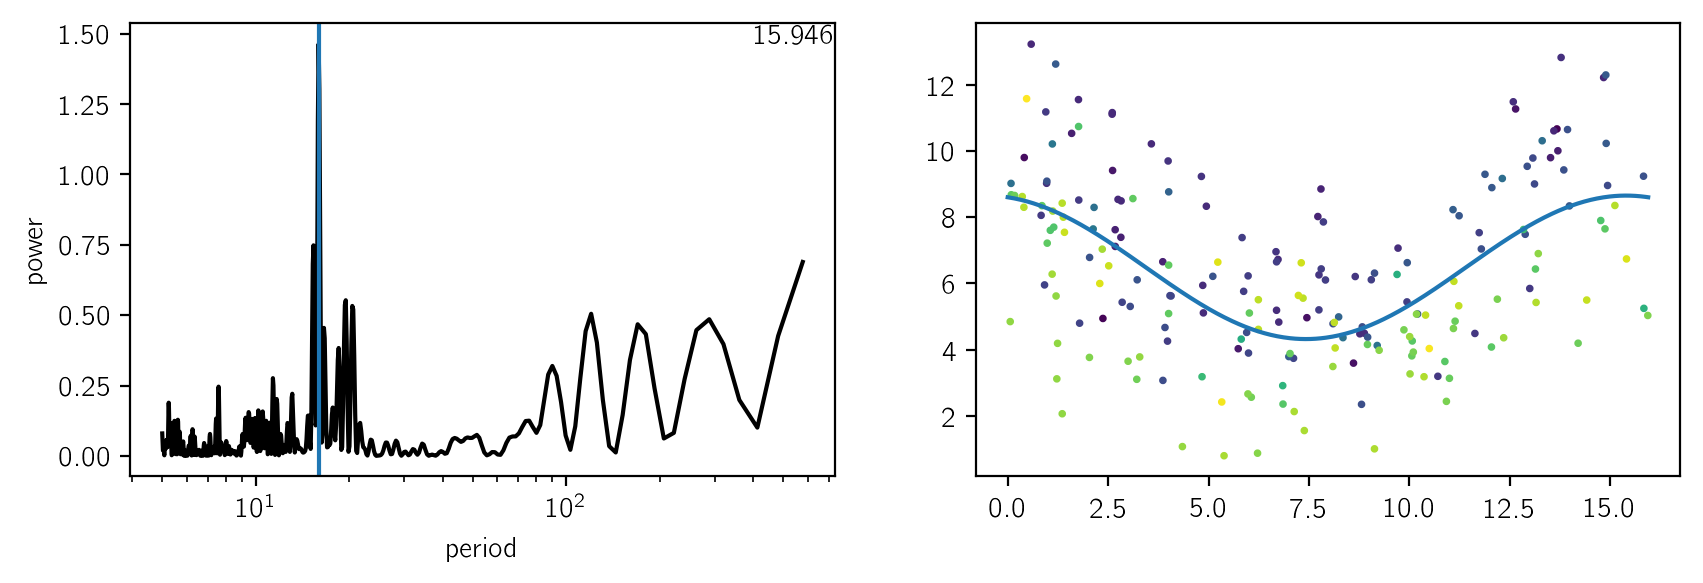

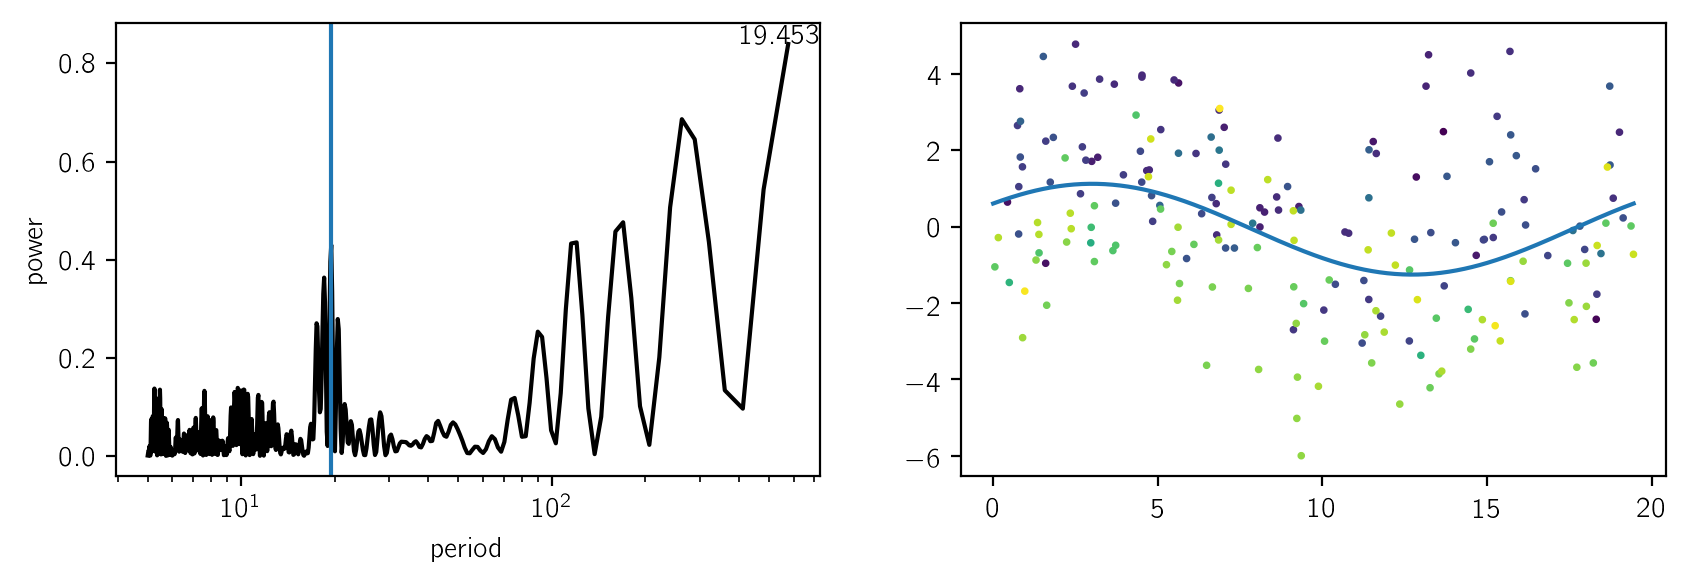

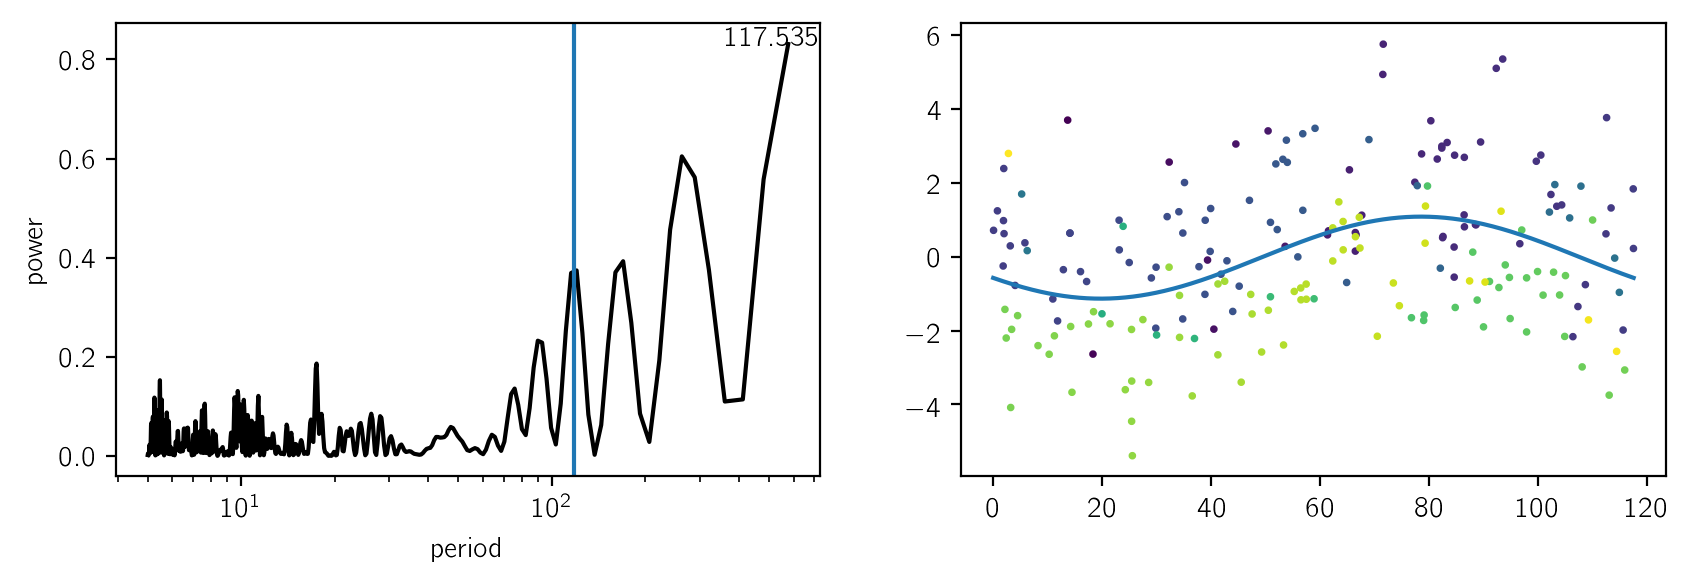

In [7]:
min_period = 5
max_period = t.max() - t.min()

y0 = np.array(y)
peaks = []
for i in range(3):
    m = lomb_scargle_estimator(t, y0, yerr, max_period=max_period, min_period=min_period, max_peaks=1,
                               filter_period=0.25*(t.max() - t.min()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.semilogx(1.0/m["periodogram"][0], m["periodogram"][1], "k")

    for peak in m["peaks"]:
        ax1.axvline(peak["period"])
    ax1.set_xlabel("period")
    ax1.set_ylabel("power")

    peak = dict(m["peaks"][0])
    A = np.vstack([
        np.sin(2*np.pi*t/peak["period"]),
        np.cos(2*np.pi*t/peak["period"]),
        np.ones_like(t),
    ]).T
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y0))
    x = np.linspace(0, peak["period"], 500)
    Am = np.vstack([
        np.sin(2*np.pi*x/peak["period"]),
        np.cos(2*np.pi*x/peak["period"]),
        np.ones_like(x),
    ]).T
    model = np.dot(Am, w)
    peak["amp"] = 0.5*(model.max() - model.min())
    peak["phase"] = np.arctan2(w[1], w[0])

    ax2.scatter(t % peak["period"], y0, c=t, s=3)
    ax2.plot(x, model)

    ax1.annotate("{0:.3f}".format(peak["period"]), xy=(1, 1),
                 xycoords="axes fraction", ha="right", va="top")
    
    y0 -= np.dot(A, w)
    
    peaks.append(peak)
    
peaks = sorted(peaks, key=lambda x: x["period"])
peaks

In [8]:
n_planets = len(peaks)
test_t = np.linspace(t.min(), t.max(), 5000)

dt = t[:, None] - t[None, :]
cov0 = 3*np.exp(-0.5*np.sin(np.pi*dt/20)**2/0.5**2 - 0.5*dt**2/50**2)
cov0[np.diag_indices_from(cov0)] += yerr**2
L0 = np.linalg.cholesky(cov0 + 0.6**2*np.eye(len(t)))

def unit_vector(name):
    vec = pm.Normal(name + "_vec", shape=(2, n_planets),
                    testval=np.random.randn(2, n_planets))
    vec = vec / tt.sqrt(tt.sum(vec**2, axis=0))[None, :]
    cos_ = vec[0]
    sin_ = vec[1]
    value = tt.arctan2(sin_, cos_)
    pm.Deterministic(name, var=value)
    return cos_, sin_, value, vec

with pm.Model() as model:
    
    logK = pm.Uniform("logK", lower=np.log(1), upper=np.log(999), shape=(n_planets,),
                      testval=np.log([p["amp"] for p in peaks]))
    logP = pm.Uniform("logP", lower=np.log(min_period), upper=np.log(max_period), shape=(n_planets,),
                      testval=np.log([p["period"] for p in peaks]))
    
    eccen = pm.Uniform("eccen", lower=0.0, upper=1.0, shape=(n_planets,))
    pm.Weibull("eccen_prior", alpha=2, beta=np.sqrt(2)*0.2, shape=(n_planets,),
               observed=eccen)
    
    cos_omega, sin_omega, omega, omega_vec = unit_vector("omega")
    cos_phi, sin_phi, phi, phi_vec = unit_vector("phi")
    
    v0 = pm.Uniform("v0", lower=-1000, upper=1000, testval=np.mean(y))
    logs2 = pm.Uniform("logs2", lower=2*np.log(1), upper=2*np.log(99))
    
    n = 2*np.pi*tt.exp(-logP)
    K = tt.exp(logK)
    s2 = tt.exp(logs2)
    pm.Deterministic("t0", var=(phi + omega) / n)

    def get_rv_models(t_):
        mean_anom = n * t_[:, None] - (phi + omega)
        eccen_arg = eccen + tt.zeros_like(mean_anom)
        eccen_anom = kepler(mean_anom, eccen_arg)
        f = 2*tt.arctan2(tt.sqrt(1+eccen)*tt.tan(0.5*eccen_anom),
                         tt.sqrt(1-eccen)+tt.zeros_like(eccen_anom))
        return K * (cos_omega*(tt.cos(f)+eccen) - sin_omega*tt.sin(f))
    
    rv_models = get_rv_models(t)
    pm.Deterministic("rv_models", var=rv_models)

    # Sum the contributions from each planet
    rv_model = v0 + tt.sum(rv_models, axis=1)
    pm.Deterministic("rv_model", var=rv_model)
    
    cov = cov0 + s2*tt.eye(len(t))
#     pm.MvNormal("obs", mu=rv_model, cov=cov, observed=y)
    pm.MvNormal("obs", mu=rv_model, chol=L0, observed=y)

#     sd = tt.sqrt(yerr**2 + s2)
#     pm.Normal("obs", mu=rv_model, sd=sd, observed=y)
    
    test_rv_models = get_rv_models(test_t)
    pm.Deterministic("test_rv_models", var=test_rv_models)
    test_rv_model = v0 + tt.sum(test_rv_models, axis=1)
    pm.Deterministic("test_rv_model", var=test_rv_model)
    
    pm.Potential("order", tt.switch(tt.all(logP[:-1] < logP[1:]), 0.0, -np.inf))
    
    pm.Deterministic("logp", var=model.logpt)

    params_no_period = [v for v in model.vars if v.name != "logP_interval__"]
    
    def find_MAP(old_res=None, vars=None, max_iter=10):
        for i in range(max_iter):
            new_res = pm.find_MAP(old_res, vars=vars)
            if old_res is not None and new_res["logp"] <= old_res["logp"] + 1e-4:
                return old_res
            old_res = new_res
        return old_res
    
    res = find_MAP(vars=[phi_vec])
    res = find_MAP(res, vars=[omega_vec])
    res = find_MAP(res, vars=params_no_period)
    res = find_MAP(res, vars=logP)
    res = find_MAP(res, vars=params_no_period)
    res = find_MAP(res, vars=logP)
    res = find_MAP(res)

#     print(res["logP"])
    trace = pm.sample(start=res, draws=2000, tune=3000)

NameError: name 'kepler' is not defined

In [ ]:
pm.traceplot(trace, varnames=["logP", "logK", "eccen", "v0", "logp"]);

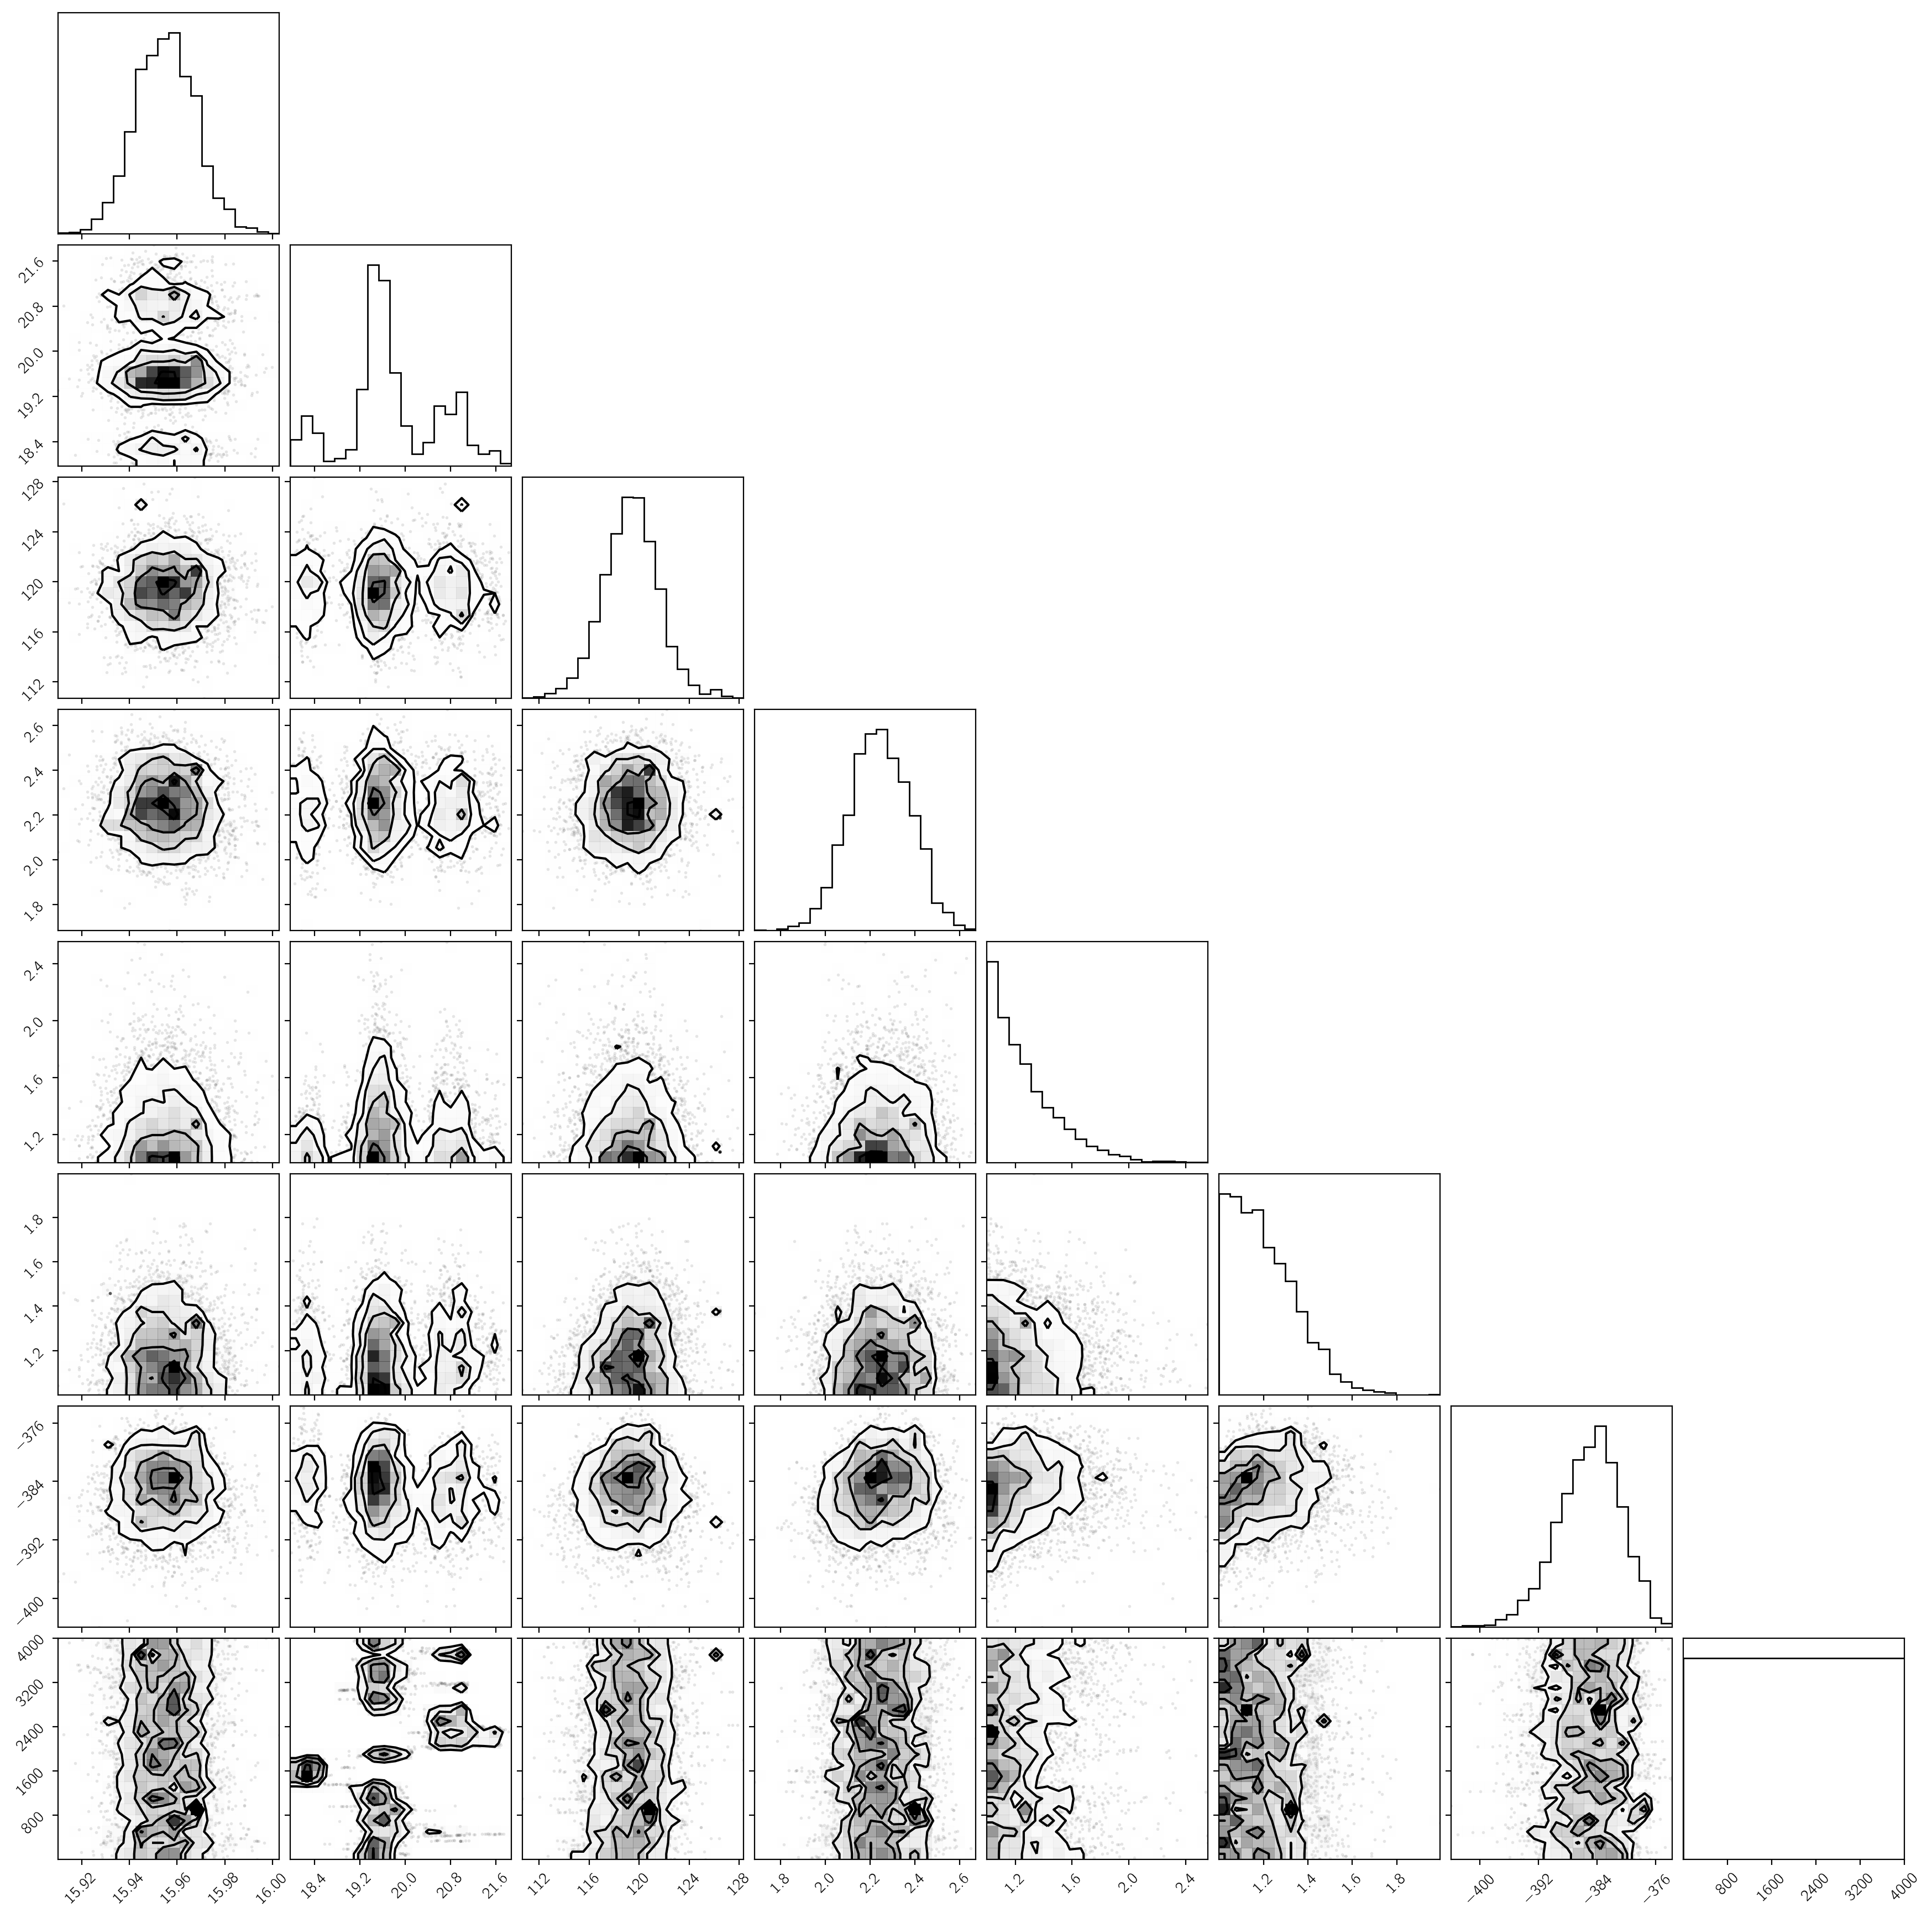

In [32]:
import corner

samples = np.concatenate([np.exp(trace[k]) for k in ["logP", "logK"]], axis=1)
samples = np.concatenate([samples, trace["logp"][:, None], np.arange(len(samples))[:, None]], axis=1)
corner.corner(samples);

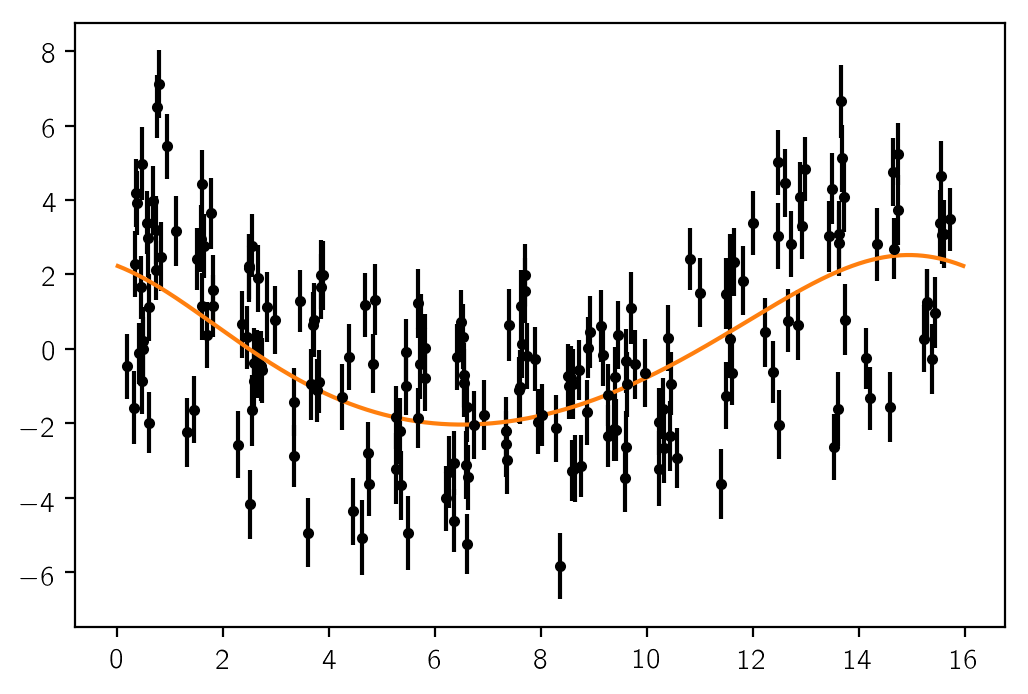

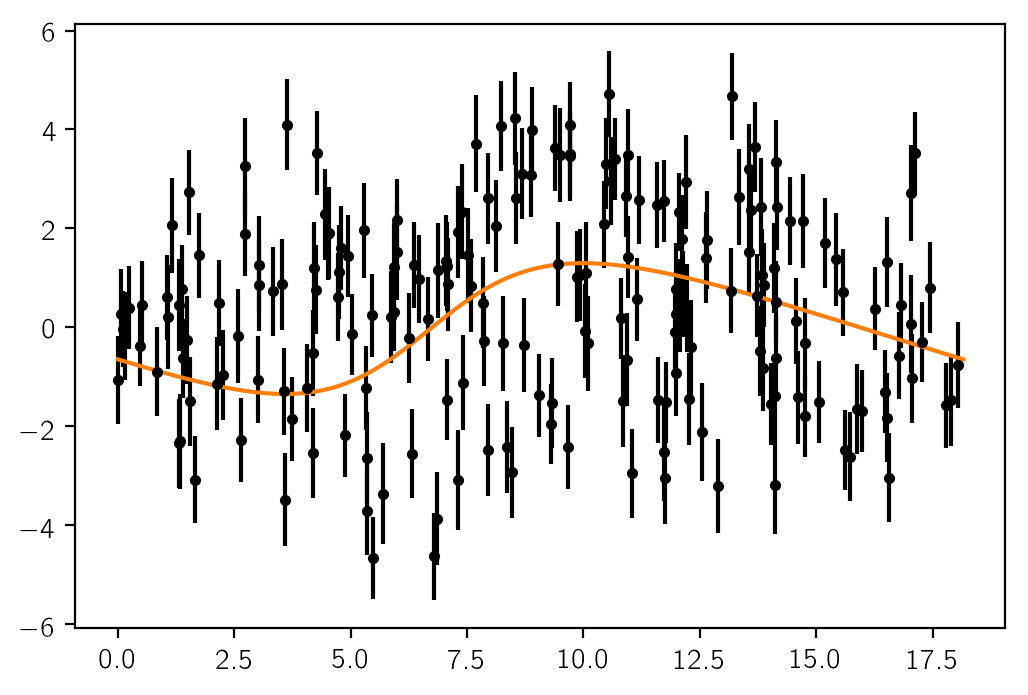

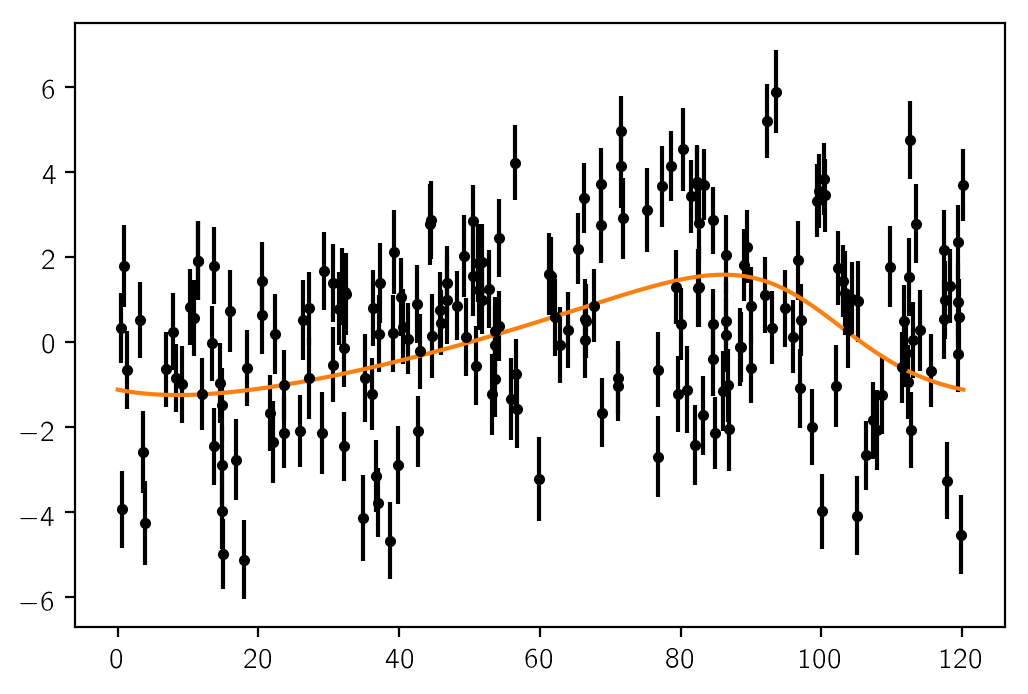

In [33]:
best_ind = int(np.argmax(trace["logp"]))
periods = np.exp(trace["logP"][best_ind])

mods = trace["rv_models"][best_ind]
resid = y - trace["rv_model"][best_ind]

for i in range(n_planets):
    plt.figure()
    period = periods[i]
    plt.errorbar(t % period, resid + mods[:, i], yerr=yerr, fmt=".k")
    x = test_t % period
    inds = np.argsort(x)
    plt.plot(x[inds], trace["test_rv_models"][best_ind][:, i][inds], color="C1")

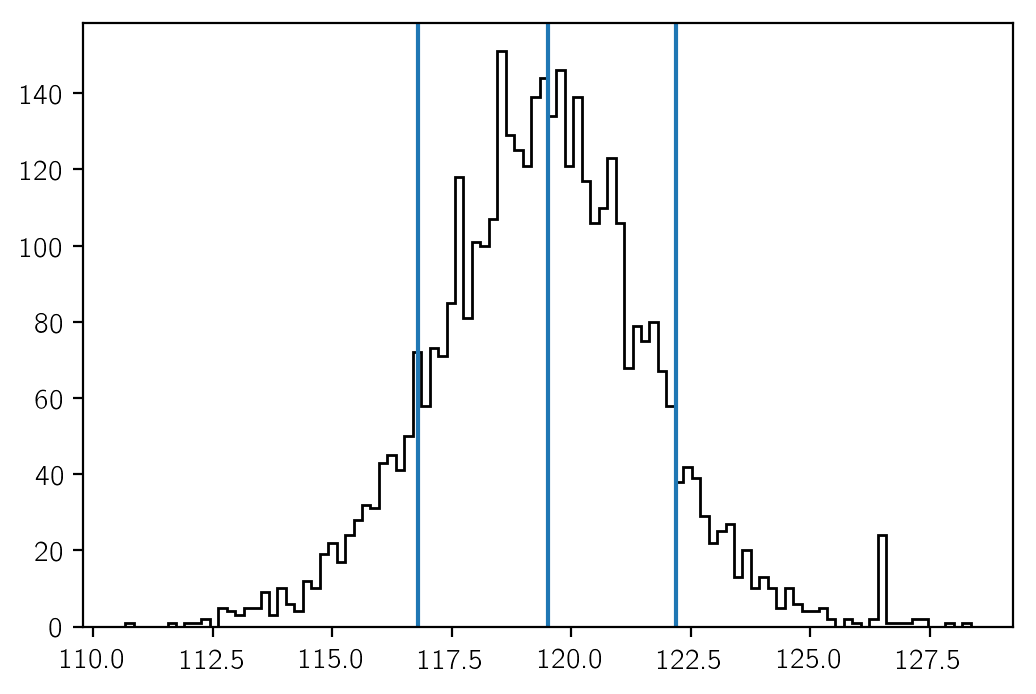

In [34]:
from scipy.cluster.vq import kmeans, whiten

x = np.exp(trace["logP"][:, -1])[:, None]
whitened = whiten(x)
means, _ = kmeans(x, 3)
means = np.sort(np.squeeze(means))

plt.hist(np.exp(trace["logP"][:, -1]), 100, histtype="step", color="k")
[plt.axvline(m) for m in means];

In [49]:
np.diff(means)

array([ 58.48149229, 119.75062982])

In [54]:
means[1] * (3 / 4)

178.53808901380424

In [58]:
means[1] * (3 / 2), means[-1]

(357.0761780276085, 357.80141516945355)

In [67]:
sorted(set([i / j for i in range(1, 6) for j in range(1, i)]))

[1.25, 1.3333333333333333, 1.5, 1.6666666666666667, 2.0, 2.5, 3.0, 4.0, 5.0]